In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import plotting
import matplotlib.style
import matplotlib.ticker as ticker

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# TODOs

* more repetitions

# DONE
* I checked that the numbers of threads chosen is beneficial for the system. We took the same numbers as Dean. If we check our speedup graph, they are the highest for us as well.
* The COV is lower than 0.1 for all systms but G1. There is is slightly above 0.1

In [2]:
pers_experiments = "(hostname == 'scyper21' or hostname == 'scyper22')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton.1", "sortledton.3", "sortledton.2", "sortledton", "stinger7-ref", "teseo-lcc.12"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

data = common.import_gfe("View_Inserts").query(pers_experiments).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data["block_size"].fillna(-1, inplace=True)
data = data.query("((block_size == 512) and library == 'sortledton.3') or library != 'sortledton.3'") 
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]

data = data.query(libraries_filter)
data = data.query("graph != 'uniform-22'")

In [3]:
data_grouped = data.groupby(["compiler_family", "graph", "library", "build_frequency", "num_threads"]) \
    .agg(std_eps=("edges_per_second", "std"), edges_per_second=("edges_per_second", "median"), count=("edges_per_second", "count"))
data_grouped["cov"] = data_grouped["std_eps"] / data_grouped["edges_per_second"]
data_grouped.drop(["std_eps"], axis=1, inplace=True)
data_grouped.index.set_names("compiler", level=1, inplace=True)
data_grouped

edges_per_second  \
compiler_family compiler       library                build_frequency num_threads                     
gcc             com-friendster g1_v6-ref-ignore-build 0 days 00:00:00 20               3.448784e+06   
                               livegraph3_ro          0 days 00:00:00 20               3.359002e+05   
                               sortledton             0 days 00:00:00 56               4.752827e+06   
                               sortledton.1           0 days 00:00:00 56               4.241223e+06   
                               sortledton.2           0 days 00:00:00 56               4.239830e+06   
                               sortledton.3           0 days 00:00:00 56               4.438972e+06   
                               teseo-lcc.12           0 days 00:00:00 56               2.802204e+06   
                dota-league    g1_v6-ref-ignore-build 0 days 00:00:00 20               3.652629e+06   
                               livegraph3_ro          0 days 00:00:00 20               3.371470e+05   
                               llama8-ref             0 days 00:00:10 16               4.206556e+05   
                               sortledton             0 days 00:00:00 56               3.704806e+06   
                               sortledton.1           0 days 00:00:00 56               3.516682e+06   
                               sortledton.2           0 days 00:00:00 56               3.450842e+06   
                               sortledton.3           0 days 00:00:00 56               3.546738e+06   
                               stinger7-ref           0 days 00:00:00 56               2.685775e+05   
                               teseo-lcc.12           0 days 00:00:00 56               2.419013e+06   
                graph500-22    g1_v6-ref-ignore-build 0 days 00:00:00 20               3.084780e+06   
                               livegraph3_ro          0 days 00:00:00 20               3.407614e+05   
                               llama8-ref             0 days 00:00:00 16               6.187644e+04   
                                                      0 days 00:00:10 16               3.563883e+05   
                               sortledton             0 days 00:00:00 56               3.530688e+06   
                               sortledton.1           0 days 00:00:00 56               4.045294e+06   
                               sortledton.2           0 days 00:00:00 56               4.013480e+06   
                               sortledton.3           0 days 00:00:00 56               4.104741e+06   
                               stinger7-ref           0 days 00:00:00 56               2.395793e+05   
                               teseo-lcc.12           0 days 00:00:00 56               2.388157e+06   
                graph500-24    g1_v6-ref-ignore-build 0 days 00:00:00 1                1.180921e+06   
                                                                      2                1.383266e+06   
                                                                      4                2.418809e+06   
                                                                      8                2.889757e+06   
                                                                      14               3.386599e+06   
                                                                      20               3.418020e+06   
                                                                      28               3.424617e+06   
                                                                      42               2.800239e+06   
                                                                      56               1.992246e+06   
                               livegraph3_ro          0 days 00:00:00 1                4.483728e+04   
                                                                      2                8.824655e+04   
                                                                  

In [4]:
stinger = pd.concat( [
    data_grouped.loc[("gcc", slice(None), "stinger7-ref", slice(None), 56)].droplevel([1])
], names=["library", "graph"], keys=["stinger"])
llama = pd.concat( [
   data_grouped.loc[("gcc", slice(None), "llama8-ref", "00:00:10", 16)].droplevel([]) # dynamic scheduling in OpenMP
], names=["library","graph"], keys=["llama"] )
graphone = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "g1_v6-ref-ignore-build", slice(None), 20)].droplevel([1])
],names=["library"], keys=["graphone"] )
livegraph = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "livegraph3_ro", slice(None), 20)].droplevel([1])
], names=["library"], keys=["livegraph"] )
teseo = data_grouped.loc[("gcc", slice(None), "teseo-lcc.12", slice(None), 56)].droplevel([1])
teseo = pd.concat([ pd.concat([teseo], axis=1 ) ], names=["library"], keys=["teseo"])
sortledton3 = data_grouped.loc[("gcc", slice(None), "sortledton.3", slice(None), 56)].droplevel([1])
sortledton2 = data_grouped.loc[("gcc", slice(None), "sortledton.2", slice(None), 56)].droplevel([1])
sortledton1 = data_grouped.loc[("gcc", slice(None), "sortledton.1", slice(None), 56)].droplevel([1])
sortledton0 = data_grouped.loc[("gcc", slice(None), "sortledton", slice(None), 56)].droplevel([1])
sortledton = pd.concat([ pd.concat([sortledton3], axis=1 ) ], names=["library"], keys=["sortledton"])

all_libs = pd.concat([stinger,llama,graphone,livegraph,teseo,sortledton])

all_libs = all_libs.pivot_table(values="edges_per_second", columns="library", index="graph")

column_order = ["sortledton", "teseo", "graphone", "stinger", "llama", "livegraph"]
all_libs = all_libs[column_order]
all_libs

library,sortledton,teseo,graphone,stinger,llama,livegraph
graph,,,,,,
com-friendster,4.438972e+06,2.802204e+06,3.448784e+06,NaN,NaN,335900.238177
dota-league,3.546738e+06,2.419013e+06,3.652629e+06,2.685775e+05,420655.625370,337146.976580
graph500-22,4.104741e+06,2.388157e+06,3.084780e+06,2.395793e+05,356388.324602,340761.356473
graph500-24,3.836104e+06,3.087181e+06,3.418020e+06,1.062412e+05,287541.723015,341502.882301
graph500-26,3.713227e+06,3.046055e+06,3.385847e+06,NaN,NaN,339519.598371
uniform-24,4.737711e+06,3.125488e+06,2.715217e+06,6.350895e+06,278022.922093,333259.927616
uniform-26,4.635443e+06,3.082991e+06,2.866200e+06,NaN,NaN,331640.543707


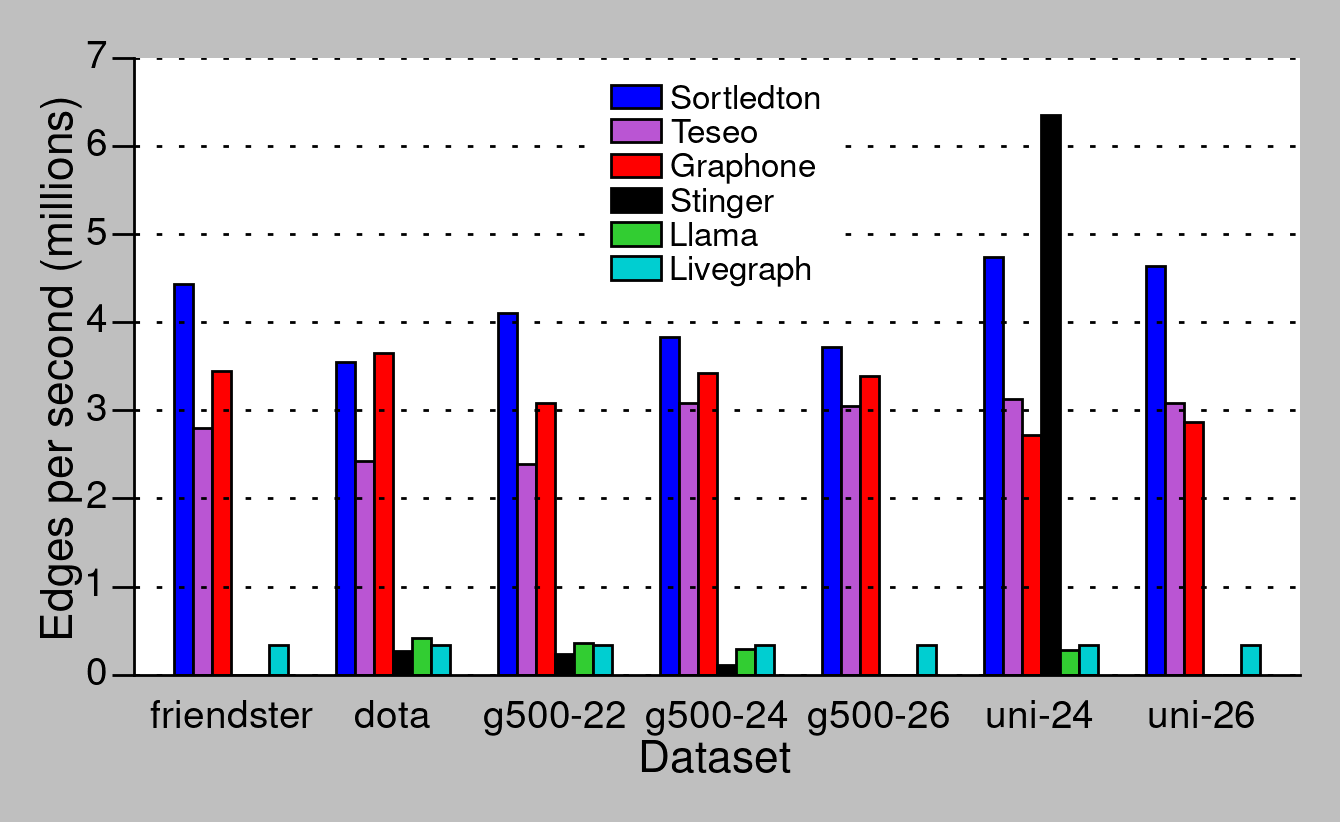

In [5]:
## FIGURE 8

matplotlib.style.use('classic')
colormap=common.set_library_colormap("")

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))

plotting.latexify()

p = all_libs.plot.bar(width=0.7, color=colormap, linewidth=0.5)
p.yaxis.set_major_formatter(ticks_y)
plt.ylabel("Edges per second (millions)")
plt.xlabel("Dataset")

positions = (0, 1, 2, 3, 4, 5, 6)
x_labels = ("friendster", "dota", "g500-22", "g500-24", "g500-26", "uni-24", "uni-26")
plt.xticks(positions, x_labels)
plt.xticks(rotation=0)
plt.yticks()


legend_labels = ["Sortledton", "Teseo", "Graphone", "Stinger", "Llama", "Livegraph"]
plt.legend(loc='upper center', labels=legend_labels).get_frame().set_linewidth(0.0)

plt.grid(axis='y')

plotting.format_axes(p, categorical_x=True)

plt.tight_layout()
plt.savefig(plotting.base_path + "insertions-new.png", dpi=400)

In [6]:
all_libs

library,sortledton,teseo,graphone,stinger,llama,livegraph
graph,,,,,,
com-friendster,4.438972e+06,2.802204e+06,3.448784e+06,NaN,NaN,335900.238177
dota-league,3.546738e+06,2.419013e+06,3.652629e+06,2.685775e+05,420655.625370,337146.976580
graph500-22,4.104741e+06,2.388157e+06,3.084780e+06,2.395793e+05,356388.324602,340761.356473
graph500-24,3.836104e+06,3.087181e+06,3.418020e+06,1.062412e+05,287541.723015,341502.882301
graph500-26,3.713227e+06,3.046055e+06,3.385847e+06,NaN,NaN,339519.598371
uniform-24,4.737711e+06,3.125488e+06,2.715217e+06,6.350895e+06,278022.922093,333259.927616
uniform-26,4.635443e+06,3.082991e+06,2.866200e+06,NaN,NaN,331640.543707


In [7]:
t = all_libs["sortledton"] - all_libs["teseo"]
t

graph
com-friendster    1.636768e+06
dota-league       1.127724e+06
graph500-22       1.716583e+06
graph500-24       7.489224e+05
graph500-26       6.671728e+05
uniform-24        1.612223e+06
uniform-26        1.552452e+06
dtype: float64

## Sorltedton.1 vs Sorltedton.0

In [8]:
sortledton0

,edges_per_second,count,cov
compiler,,,
com-friendster,4.752827e+06,10,0.025714
dota-league,3.704806e+06,11,0.162578
graph500-22,3.530688e+06,34,0.229224
graph500-24,4.149446e+06,13,0.064424
graph500-26,3.951713e+06,18,0.125027
uniform-24,5.619842e+06,14,0.025753
uniform-26,5.629764e+06,10,0.028244


In [9]:
sortledton1

,edges_per_second,count,cov
compiler,,,
com-friendster,4.241223e+06,8,0.030261
dota-league,3.516682e+06,10,0.018014
graph500-22,4.045294e+06,8,0.021736
graph500-24,3.804796e+06,11,0.024100
graph500-26,3.618791e+06,9,0.020533
uniform-24,5.053708e+06,8,0.038792
uniform-26,4.962436e+06,8,0.027047


In [10]:
sortledton2

,edges_per_second,count,cov
compiler,,,
com-friendster,4.239830e+06,5,0.049121
dota-league,3.450842e+06,5,0.026996
graph500-22,4.013480e+06,5,0.034546
graph500-24,3.660557e+06,5,0.032252
graph500-26,3.631511e+06,5,0.005590
uniform-24,4.622535e+06,5,0.055379
uniform-26,4.897837e+06,5,0.047353


Sortledton.1 is often up to 0.7 million edges slower than Sortledton.0. 

There are two possible reasons for this:
1. The locks are hold longer now because we draw the timestamp within the locked period. This is unlikely.
2. Using std::forward_list to version adjacency sizes is slower than my own list which reused garbage collected elements. This is likely.

I tested 2. by using `splice_after` to reuse linked list entries. This is not the issue.